In [1]:
import numpy as np
import xarray as xr
import scipy.io as sio

import pandas as pd

import matplotlib.pyplot as plt

In [2]:
# NCL colormap
import matplotlib
import colormath, colormath.color_objects, colormath.color_conversions
from colormath.color_objects import sRGBColor
import urllib
import re

In [3]:
color_obj_dict = {'sRGB':colormath.color_objects.sRGBColor,
                  'HSV':colormath.color_objects.HSVColor,
                  'Lab':colormath.color_objects.LabColor,
                  'LCHuv':colormath.color_objects.LCHuvColor,
                  'LCHab':colormath.color_objects.LCHabColor,
                  'XYZ':colormath.color_objects.XYZColor}

def __rgb_to_array(rgb_color):
    r = np.minimum(1, round(rgb_color.rgb_r*10000)/10000)
    g = np.minimum(1, round(rgb_color.rgb_g*10000)/10000)
    b = np.minimum(1, round(rgb_color.rgb_b*10000)/10000)
    return r,g,b


def create_palette(start_rgb, end_rgb, n, colorspace):
    # convert start and end to a point in the given colorspace
    start = colormath.color_conversions.convert_color(start_rgb, colorspace).get_value_tuple()
    end = colormath.color_conversions.convert_color(end_rgb, colorspace).get_value_tuple()

    # create a set of n points along start to end
    points = list(zip(*[np.linspace(start[i], end[i], n) for i in range(3)]))

    # create a color for each point and convert back to rgb
    rgb_colors = [colormath.color_conversions.convert_color(colorspace(*point), sRGBColor) for point in points]

    # convert rgb colors to arrays
    return [__rgb_to_array(color) for color in  rgb_colors]


def __retrive_NCL_webcontent(cmapname):
    target_url = 'https://www.ncl.ucar.edu/Document/Graphics/ColorTables/Files/%s.rgb' % cmapname
    request = urllib.request.urlopen(target_url)
    return request


def __collect_discrete_NCL_cmap(cmapname):
    rawdata = __retrive_NCL_webcontent(cmapname)
    
    cmap_color_list = list()
    
    color_section_sig = 0
    
    for line in rawdata:
        
        line_decode = line.decode('utf-8')
        info = re.split('\s+', line_decode.replace('\n','').replace('^\s+',''))
        
        if color_section_sig==1:
            if info[0]=='' and len(info)>=3:
                if np.maximum(np.maximum(float(info[1]), float(info[2])), float(info[3]))>1:
                    cmap_color_list.append((float(info[1])/255, float(info[2])/255, float(info[3])/255))
                else:
                    cmap_color_list.append((float(info[1]), float(info[2]), float(info[3])))
            if len(info)==3:
                if ';' in info[0] or '#' in info[0]:
                    whatisthis = 's'
                else:
                    if np.maximum(np.maximum(float(info[0]), float(info[1])), float(info[2]))>1:
                        cmap_color_list.append((float(info[0])/255, float(info[1])/255, float(info[2])/255))
                    else:
                        cmap_color_list.append((float(info[0]), float(info[1]), float(info[2])))
        
        if 'ncolors' in str(info[0]):
            color_section_sig = 1  # meaning now we are at color lines (or "r g b" line)

    return cmap_color_list


def __cmap_refinement(raw_cmap_rgb, n_interpolate=10, workspace=color_obj_dict['sRGB']):
    # workspace:  choose which color space the refinement is conducted.
    #             refer to https://stackoverflow.com/questions/55032648/given-a-start-color-and-a-middle-color-how-to-get-the-remaining-colors-python
    
    n_in = len(raw_cmap_rgb)

    new_array = list()

    for i in np.arange(n_in-1):
        out_colors = create_palette(sRGBColor(*raw_cmap_rgb[i], is_upscaled=False), sRGBColor(*raw_cmap_rgb[i+1], is_upscaled=False), n_interpolate+1, workspace)
        for j in np.arange(len(out_colors)-1):
            new_array.append(out_colors[j])
            
    return new_array


def generate_NCL_cmap(cmapname, cont_opt=False, cont_param_n=10, cont_param_ws='sRGB',
                      white_first=False, white_ext=False, reverse_cmap=False):
    # description:
    #     cmapname:      taken as shown on the NCL website
    #     cont_opt:      to convert the discreate colormap to continuous colormap
    #     cont_param_n:  how many "intermediate" colors to be inserted to the nearby discreate colors
    #     cont_param_ws: color space to conduct interploation. Default to "sRGB", which should work for most cases
    #     white_first:   whether to set the first color as white. May be useful if the minimum does not mean anything
    
    cmap_discrete_raw = __collect_discrete_NCL_cmap(cmapname)
    
    if reverse_cmap==True:
        cmap_discrete_raw.reverse()
    
    if white_first==True:
        if white_ext==True:
            cmap_discrete = list()
            cmap_discrete.append((1,1,1))
            for i in np.arange(len(cmap_discrete_raw)):
                cmap_discrete.append(cmap_discrete_raw[int(i)])
        else:
            cmap_discrete = cmap_discrete_raw.copy()
        cmap_discrete[0] = (1,1,1)
    else:
        cmap_discrete = cmap_discrete_raw
    
    if cont_opt==False:
        out_cmap = cmap_discrete
        
    if cont_opt==True:
        out_cmap = __cmap_refinement(cmap_discrete, n_interpolate=cont_param_n, workspace=color_obj_dict[cont_param_ws])
        
    return matplotlib.colors.ListedColormap(out_cmap)

def crt_cbar_labels(vmax, n_interval, mode='diff', decimal_flag=0, perc_flag=False, vmin=0):
    # crt_cbar_labels:  create the colorbar label lists
    #   mode:  choose between "diff" and "0ton". "diff" means setting the colorbar as -vmax to vmax, "0ton" 
    #          means setting the colorbar as 0 to vmax
    #   n_interval:  how many segments are there? See example below.
    #   decimal_flag:  control the text format. Default to 0.
    #
    # Example:
    #      > crt_cbar_labels(80, 4, mode='diff', decimal_flag=0)
    #      >  ['-80', '-40', '0', '40', '80']
    #      > crt_cbar_labels(80, 4, mode='0ton', decimal_flag=1)
    #      >  ['0.0', '20.0', '40.0', '60.0', '80.0']
    
    if perc_flag==True:
        format_string = '%%.%df%%%%' % (decimal_flag)
    else:
        format_string = '%%.%df' % (decimal_flag)
    #print(format_string)
    outdata = []
    
    if mode=='diff':
        n_interval = n_interval/2
        for i in np.arange(-1*n_interval, n_interval+0.000001, 1):
            outdata.append(format_string%(vmax*i/n_interval))
    if mode=='0ton':
        for i in np.arange(0, n_interval+0.000001, 1):
            outdata.append(format_string%(vmax*i/n_interval))
    if mode=='minmax':
        for i in np.arange(0, n_interval+0.000001, 1):
            outdata.append(format_string%(vmin + (vmax-vmin)*i/n_interval))
        
    return outdata

In [4]:
rootdir = '/raid1/chen423/serdp/archive/GRL2020/'

plotdir = rootdir + 'plots/'

In [5]:
ARtag = 'abs'
flag_area = 1000   # minimum size of patches (over land and over ocean, both)
flag_USstate = 1  # whether to use US west coast 5 states along with land mask. 1 is to use, 0 is to skip
flag_post_adj = 1  # WRF further adjusted, or not (i.e., directly from modified NARR). 1 is further adjusted, 0 for raw

commonAR_thre = 1000

version_tag = 'AR%s_s%d_state%d_post%d_c%d' % (ARtag, flag_area, flag_USstate, flag_post_adj, commonAR_thre)
print(version_tag)

ARp85_s1000_state1_post1_c1000


In [6]:
def crt_refdata():
    reffile = rootdir + 'data/common_ref/latlon.nc'
    lats = xr.open_dataset(reffile).XLAT_M.values
    lons = xr.open_dataset(reffile).XLONG_M.values
    
    return lats, lons
    
wrf_lats, wrf_lons = crt_refdata()

reffile = rootdir + 'data/common_ref/SERDP6km.dist_to_coastal.nc'
dist_to_coast = xr.open_dataset(reffile).dist_to_coast.values
dist_to_coast[dist_to_coast==9999] = 0
ocean_mask = np.zeros((450,450))
ocean_mask[dist_to_coast==0] = 1


reffile = rootdir + 'data/common_ref/US_state.nc'
USstate = 1-xr.open_dataset(reffile).state_mask.values[0:5].sum(axis=0)

In [7]:
def compute_regr_coeffs(x, iny):
    #nt = np.ones(iny.shape[0])
    
    k = ((x*(iny-iny.mean())).sum()) / ((x*(x-x.mean())).sum())
    #k = ((x-x.mean())*(iny-iny.mean())).sum() / ((x-x.mean())*(x-x.mean())).sum()
    b = iny.mean() - k * x.mean()
    
    return k, b

## 1. SST

In [8]:
def compute_SSTmean(in_SST):
    mask_full = ocean_mask==1
    out_SSTmean_all = in_SST[mask_full].mean()
    
    return out_SSTmean_all

In [9]:
infile = rootdir + 'data/HIST/SST_background/NARR_TS.SERDP6km.2000.10.01.00.nc'
fSST_full = xr.open_dataset(infile).var11.values[0]

fSST = compute_SSTmean(fSST_full)

###  using daily SST to compute difference

In [10]:
def retrieve_daily_SST():
    # use daily SST
    infile = rootdir + 'data/HIST/SST_background/NARR_TS.SERDP6km.6hourly.200310-201509.daymean.nc'
    in_SSTday_maps = xr.open_dataset(infile).var11.values

    return np.array([compute_SSTmean(in_SSTday_maps[i]) for i in np.arange(4383)])

SSTmean_series = retrieve_daily_SST()

In [11]:
SSTdiff = fSST-SSTmean_series

## 2. P data

In [12]:
def get_masked_Pdata(scenario, P_thre=1):
    if scenario == 'HIST':
        infile = rootdir + 'data/HIST/P/WRF_NARR.point.PREC_ACC_NC.20031001-20150930.nc'
    elif scenario == 'fSST':
        infile = rootdir + 'data/fSST/P/WRF_NARR_fSST.point.PREC_ACC_NC.20031001-20150930.nc'

    tmpdata = xr.open_dataset(infile).PREC_ACC_NC.values
    out_P = np.ma.masked_array(tmpdata, mask=tmpdata<P_thre)
    
    return out_P

In [13]:
def compute_P_regionalmean(in_P):
    outdata = np.zeros((3,4383))
    for i in np.arange(4383):
        if ((USstate==0)&(in_P[i]>0)).sum()>1000: # was 10
            outdata[0,i] = in_P[i][USstate==0].sum()
            outdata[1,i] = in_P[i][USstate==0].mean()
            outdata[2,i] = ((USstate==0)&(in_P[i]>0)).sum()
        
    return outdata

In [14]:
def gen_HIST(P_thre=1):
    P_HIST = get_masked_Pdata(scenario='HIST', P_thre=P_thre)

    Preg_HIST = compute_P_regionalmean(P_HIST)
    
    return Preg_HIST


def gen_fSST(P_thre=1):
    P_fSST = get_masked_Pdata(scenario='fSST', P_thre=P_thre)

    Preg_fSST = compute_P_regionalmean(P_fSST)
    
    return Preg_fSST

In [15]:
Preg_HIST = gen_HIST()
Preg_fSST = gen_fSST()

## 3. AR data

In [16]:
tmpfile = rootdir + 'data/intermediate_data/AR_stats_separate.%s.mat' % version_tag
AR6hr_index = sio.loadmat(tmpfile)['ARday_index']

ts_daily = pd.period_range(start='2003-10-01', end='2015-09-30', freq='D')

# for each day, consider the 5 6-hrly snaps (0,6,12,18,24). If there are more than X snaps with AR, then it is an AR day
thre_6hr_to_day = 2  # the X

ARday_index_2sets = np.zeros((2, 4383))

for i in np.arange(4383):
    sindex = i*4
    eindex = (i+1)*4
    #print(sindex, eindex)
    for j in [0,1]:
        if AR6hr_index[j, sindex:(eindex+1)].sum()>=thre_6hr_to_day:
            ARday_index_2sets[j, i] = 1

ARday_index = ARday_index_2sets
            
#ARday_index = np.zeros((2,4383))
#for i in np.arange(2):
#    ARday_index[i,:] = ARday_index_2sets.sum(axis=0)==2
    
print(ARday_index[0].sum(), ARday_index[1].sum())

643.0 678.0


In [17]:
tmpfile = rootdir + 'data/intermediate_data/AR_stats_separate.%s.mat' % version_tag
AR6hr_index = sio.loadmat(tmpfile)['ARday_index']

In [18]:
AR6hr_index.sum(axis=1)

array([1965., 2070.])

In [19]:
ts_daily = pd.period_range(start='2003-10-01', end='2015-09-30', freq='D')

In [20]:
#np.where(((ts_daily.year.values==2012) & (ts_daily.month.values==5) & (ts_daily.day.values==17))==1)

#np.where(((ts_daily.year.values==2014) & (ts_daily.month.values==12) & (ts_daily.day.values==3))==1)

In [21]:
SST_valid = np.ones(4383)
for i in [3151, 3152, 4081, 4082]:
    SST_valid[i] = 0

In [22]:
# for each day, consider the 5 6-hrly snaps (0,6,12,18,24). If there are more than X snaps with AR, then it is an AR day
thre_6hr_to_day = 2  # the X

ARday_index_2sets = np.zeros((2, 4383))

for i in np.arange(4383):
    sindex = i*4
    eindex = (i+1)*4
    #print(sindex, eindex)
    for j in [0,1]:
        if AR6hr_index[j, sindex:(eindex+1)].sum()>=thre_6hr_to_day:
            ARday_index_2sets[j, i] = 1

ARday_index = ARday_index_2sets
            
#ARday_index = np.zeros((2,4383))
#for i in np.arange(2):
#    ARday_index[i,:] = ARday_index_2sets.sum(axis=0)==2
    
print(ARday_index[0].sum(), ARday_index[1].sum())

643.0 678.0


## 4. analysis


### 4.1 response of P to same ARs

In [23]:
index_common_AR_events = (Preg_HIST[0]>0)&(Preg_fSST[0]>0)&(ARday_index.sum(axis=0)==2)&(SST_valid==1)
index_HIST_AR_events = (Preg_HIST[0]>0)&(ARday_index[0]==1)&(SST_valid==1)
index_fSST_AR_events = (Preg_fSST[0]>0)&(ARday_index[1]==1)&(SST_valid==1)
index_common_nAR_events = (Preg_HIST[0]>0)&(Preg_fSST[0]>0)&(ARday_index.sum(axis=0)==0)&(SST_valid==1)
index_HIST_nAR_events = (Preg_HIST[0]>0)&(ARday_index[0]==0)&(SST_valid==1)
index_fSST_nAR_events = (Preg_fSST[0]>0)&(ARday_index[1]==0)&(SST_valid==1)

print(index_common_AR_events.sum(), index_HIST_AR_events.sum(), index_fSST_AR_events.sum())
print(index_common_nAR_events.sum(), index_HIST_nAR_events.sum(), index_fSST_nAR_events.sum())

555 579 618
2681 2757 2816


In [24]:
index = 0
k_total_y, b_total_y = compute_regr_coeffs(SSTdiff[index_common_AR_events], Preg_fSST[index][index_common_AR_events]/Preg_HIST[index][index_common_AR_events]-1)
k_total_n, b_total_n = compute_regr_coeffs(SSTdiff[index_common_nAR_events], Preg_fSST[index][index_common_nAR_events]/Preg_HIST[index][index_common_nAR_events]-1)

index = 1
k_int_y, b_int_y = compute_regr_coeffs(SSTdiff[index_common_AR_events], Preg_fSST[index][index_common_AR_events]/Preg_HIST[index][index_common_AR_events]-1)
k_int_n, b_int_n = compute_regr_coeffs(SSTdiff[index_common_nAR_events], Preg_fSST[index][index_common_nAR_events]/Preg_HIST[index][index_common_nAR_events]-1)

index = 2
k_area_y, b_area_y = compute_regr_coeffs(SSTdiff[index_common_AR_events], Preg_fSST[index][index_common_AR_events]/Preg_HIST[index][index_common_AR_events]-1)
k_area_n, b_area_n = compute_regr_coeffs(SSTdiff[index_common_nAR_events], Preg_fSST[index][index_common_nAR_events]/Preg_HIST[index][index_common_nAR_events]-1)


print(k_total_y, b_total_y)
print(' ', k_total_n, b_total_n)
print(k_int_y, b_int_y)
print(' ', k_int_n, b_int_n)
print(k_area_y, b_area_y)
print(' ', k_area_n, b_area_n)

0.01531755919028959 0.06288353606973128
  0.08543579873874456 0.055489689932157304
0.012061992951912197 0.023021248689191653
  0.033102671477525825 0.023950065853335964
0.0033007434045981875 0.035500401417091446
  0.037877286587299344 0.032027759261690616


### 4.2 IWV sensitivity

In [25]:
tmpfile = rootdir + 'data/intermediate_data/full_ocean_stats_separate.mat'
    
stats_SSTmean = sio.loadmat(tmpfile)['stats_SSTmean']
stats_IVT = sio.loadmat(tmpfile)['stats_IVT']
stats_IWV = sio.loadmat(tmpfile)['stats_IWV']
stats_IVTf = sio.loadmat(tmpfile)['stats_IVTf']
stats_IWVf = sio.loadmat(tmpfile)['stats_IWVf']

In [26]:
tmpfile = rootdir + 'data/intermediate_data/AR_stats_separate.%s.mat' % version_tag
AR6hr_index = sio.loadmat(tmpfile)['ARday_index']
common_AR = (AR6hr_index.sum(axis=0))==2
common_nAR = (AR6hr_index.sum(axis=0))==0

In [27]:
def compute_IWV_IVT_SST_pairs(ARcase, region='ocean'):
    # region: "ocean" or "all"
    if ARcase=='AR':
        valid_index = (common_AR==1)*(np.abs(stats_SSTmean[0]-stats_SSTmean[1])>=0.1)
    elif ARcase=='nAR':
        valid_index = (common_nAR==1)*(np.abs(stats_SSTmean[0]-stats_SSTmean[1])>=0.1)

    valid_SSTmean = stats_SSTmean[:,valid_index==1]
    
    if region=='ocean':
        valid_IVT = stats_IVT[:, valid_index==1]
        valid_IWV = stats_IWV[:, valid_index==1]
    elif region=='all':
        valid_IVT = stats_IVTf[:, valid_index==1]
        valid_IWV = stats_IWVf[:, valid_index==1]
        
    diff_SST = valid_SSTmean[1]-valid_SSTmean[0]
    diff_IVT = valid_IVT[1]/valid_IVT[0]-1
    diff_IWV = valid_IWV[1]/valid_IWV[0]-1
        
    
    print('There are %d valid 6-hr snaps with co-occurrence of ARs' % valid_index.sum())
    
    return diff_SST, diff_IVT, diff_IWV

In [28]:
diff_SST_AR, diff_IVT_AR, diff_IWV_AR = compute_IWV_IVT_SST_pairs('AR', region='ocean')
diff_SST_nAR, diff_IVT_nAR, diff_IWV_nAR = compute_IWV_IVT_SST_pairs('nAR', region='ocean')

There are 1835 valid 6-hr snaps with co-occurrence of ARs
There are 14945 valid 6-hr snaps with co-occurrence of ARs


In [29]:
k_IVT_AR, b_IVT_AR = compute_regr_coeffs(diff_SST_AR, diff_IVT_AR)
k_IVT_nAR, b_IVT_nAR = compute_regr_coeffs(diff_SST_nAR, diff_IVT_nAR)
k_IWV_AR, b_IWV_AR = compute_regr_coeffs(diff_SST_AR, diff_IWV_AR)
k_IWV_nAR, b_IWV_nAR = compute_regr_coeffs(diff_SST_nAR, diff_IWV_nAR)

In [30]:
import scipy.stats.distributions as dist


def check_mean_zero_significance(indata, thre_p=0.1):
    n = indata.shape[0]
    se = indata.std()/np.sqrt(n)
    be = indata.mean()
    he = 0
    test_statistic = (be - he)/se
    
    pvalue = 2*dist.norm.cdf(-np.abs(test_statistic))
    
    if np.abs(pvalue)<thre_p:
        sig = 1
    else:
        sig = 0
    
    return sig

In [31]:
def barplot_double_set(axis, in_x, indata, inlabels, incolors):
    patch_collection_for_legend = []
    for i in np.arange(nbins):
        threb = -1*xmax+i*xres
        threu = -1*xmax+(i+1)*xres
        loc_v = (threb+threu)/2
        index1 = (in_x[0]>threb)*(in_x[0]<=threu)
        index2 = (in_x[1]>threb)*(in_x[1]<=threu)
        #print(index1.sum())
        if index1.sum()>10:
            plotdata = [indata[0][index1], indata[1][index2]]
            sigs = [check_mean_zero_significance(plotdata[0]), check_mean_zero_significance(plotdata[1])]
            #bplot1 = ax1.boxplot(plotdata, positions=np.arange(loc_v-1*para_a-1*para_b, loc_v+1*para_a+1*para_b+0.0000001, para_a+para_b), widths=para_a,
            #            showfliers=False, whis=[10,90], patch_artist=True)
            bplot1 = axis.boxplot(plotdata, positions=np.arange(loc_v-0.5*para_a-0.5*para_b, loc_v+0.5*para_a+0.5*para_b+0.0000001, para_a+para_b), widths=para_a,
                        showfliers=False, whis=[10,90], patch_artist=True)
            for patch, color, sig in zip(bplot1['boxes'], incolors, sigs):
                if sig==1:
                    patch.set_facecolor(color)
                    patch.set_edgecolor(color) 
                if sig==0:
                    patch.set_facecolor('none')
                    patch.set_edgecolor('black')
                if i==7:
                    patch_collection_for_legend.append(patch)
            if i==7:
                leg = axis.legend(patch_collection_for_legend,
                                 inlabels, ncol=2, loc='upper center',
                                 frameon=False, fontsize=11)
                for legobj in leg.legendHandles:
                    legobj.set_linewidth(0)

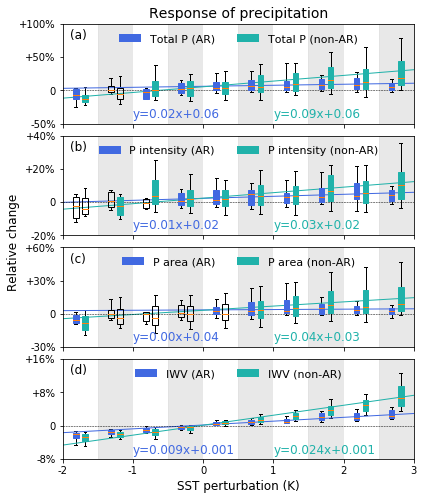

In [33]:
para_a = 0.08 # bin width
para_b = 0.05 # bin interval

xmax = 3
xres = 0.5
nbins = int(xmax*2/xres)
H_interval=xres

xdata = np.arange(-3, 6.1, 1)

fig2 = plt.figure(figsize=(7,8))
rowspan=10
colspan=9
ax1 = plt.subplot2grid((43,10), (0,0), colspan=colspan, rowspan=rowspan)
ax2 = plt.subplot2grid((43,10), (11,0), colspan=colspan, rowspan=rowspan)
ax3 = plt.subplot2grid((43,10), (22,0), colspan=colspan, rowspan=rowspan)
ax4 = plt.subplot2grid((43,10), (33,0), colspan=colspan, rowspan=rowspan)
axes_full = [ax1, ax2 ,ax3, ax4]


barplot_double_set(ax1, [SSTdiff[index_common_AR_events], SSTdiff[index_common_nAR_events]],
                   [(Preg_fSST[0][index_common_AR_events]/Preg_HIST[0][index_common_AR_events]-1)*100,
                    (Preg_fSST[0][index_common_nAR_events]/Preg_HIST[0][index_common_nAR_events]-1)*100],
                   ['Total P (AR)', 'Total P (non-AR)'], ['royalblue', 'lightseagreen'])
ax1.plot(xdata, (xdata*k_total_y+b_total_y)*100, lw=1, color='royalblue')
ax1.plot(xdata, (xdata*k_total_n+b_total_n)*100, lw=1, color='lightseagreen')

barplot_double_set(ax2, [SSTdiff[index_common_AR_events], SSTdiff[index_common_nAR_events]],
                   [(Preg_fSST[1][index_common_AR_events]/Preg_HIST[1][index_common_AR_events]-1)*100,
                    (Preg_fSST[1][index_common_nAR_events]/Preg_HIST[1][index_common_nAR_events]-1)*100],
                   ['P intensity (AR)', 'P intensity (non-AR)'], ['royalblue', 'lightseagreen'])
ax2.plot(xdata, (xdata*k_int_y+b_int_y)*100, lw=1, color='royalblue')
ax2.plot(xdata, (xdata*k_int_n+b_int_n)*100, lw=1, color='lightseagreen')

barplot_double_set(ax3, [SSTdiff[index_common_AR_events], SSTdiff[index_common_nAR_events]],
                   [(Preg_fSST[2][index_common_AR_events]/Preg_HIST[2][index_common_AR_events]-1)*100,
                    (Preg_fSST[2][index_common_nAR_events]/Preg_HIST[2][index_common_nAR_events]-1)*100],
                   ['P area (AR)', 'P area (non-AR)'], ['royalblue', 'lightseagreen'])
ax3.plot(xdata, (xdata*k_area_y+b_area_y)*100, lw=1, color='royalblue')
ax3.plot(xdata, (xdata*k_area_n+b_area_n)*100, lw=1, color='lightseagreen')

barplot_double_set(ax4, [diff_SST_AR, diff_SST_nAR], [diff_IWV_AR*100, diff_IWV_nAR*100],
                   ['IWV (AR)', 'IWV (non-AR)'], ['royalblue', 'lightseagreen'])
ax4.plot(xdata, (xdata*k_IWV_AR+b_IWV_AR)*100, lw=1, color='royalblue')
ax4.plot(xdata, (xdata*k_IWV_nAR+b_IWV_nAR)*100, lw=1, color='lightseagreen')

# decoration
for i in np.arange(nbins):
    threb = -1*xmax+i*xres
    threu = -1*xmax+(i+1)*xres
    for axis in axes_full:
        # background       
        if i%2==0:
            patch = matplotlib.patches.Rectangle((threb,-1000), H_interval, 2000, color='white', alpha=1, zorder=0)
        else:
            patch = matplotlib.patches.Rectangle((threb,-1000), H_interval, 2000, color='lightgray', alpha=0.5, zorder=0)
        axis.add_patch(patch)
         
for axis in axes_full:
    axis.plot(np.arange(-20, 20), np.zeros(40), linestyle='--', linewidth=0.5, color='black')
    axis.set_xlim([-2, xmax])
    axis.set_xticks(np.arange(-2, xmax+0.000001, 1))
    axis.set_xticklabels(np.arange(-2, xmax+xres+0.000001, 1, dtype=int))

#ax3.text(-2.5, 60, 'Relative change\n(%)', ha='center', va='center', rotation=90, fontsize=14)
    
ax1.set_ylim([-50, 100])
ax1.set_yticks([-50, 0, 50, 100])
ax1.set_yticklabels(['-50%', '0', '+50%', '+100%'])
ax1.text(-1, -50+150/30, 'y=%.2fx+%.2f' % (k_total_y, b_total_y), color='royalblue', ha='left', va='bottom', fontsize=12)
ax1.text(1, -50+150/30, 'y=%.2fx+%.2f' % (k_total_n, b_total_n), color='lightseagreen', ha='left', va='bottom', fontsize=12)
ax2.set_ylim([-20, 40])
ax2.set_yticks([-20, 0, 20, 40])
ax2.set_yticklabels(['-20%', '0', '+20%', '+40%'])
ax2.text(-1, -20+60/30, 'y=%.2fx+%.2f' % (k_int_y, b_int_y), color='royalblue', ha='left', va='bottom', fontsize=12)
ax2.text(1, -20+60/30, 'y=%.2fx+%.2f' % (k_int_n, b_int_n), color='lightseagreen', ha='left', va='bottom', fontsize=12)
ax3.set_ylim([-30, 60])
ax3.set_yticks([-30, 0, 30, 60])
ax3.set_yticklabels(['-30%', '0', '+30%', '+60%'])
ax3.text(-1, -30+90/30, 'y=%.2fx+%.2f' % (k_area_y, b_area_y), color='royalblue', ha='left', va='bottom', fontsize=12)
ax3.text(1, -30+90/30, 'y=%.2fx+%.2f' % (k_area_n, b_area_n), color='lightseagreen', ha='left', va='bottom', fontsize=12)
ax4.set_ylim([-8, 16])
ax4.set_yticks([-8, 0, 8, 16])
ax4.set_yticklabels(['-8%', '0', '+8%', '+16%'])
ax4.text(-1, -8+16/30, 'y=%.3fx+%.3f' % (k_IWV_AR, b_IWV_AR), color='royalblue', ha='left', va='bottom', fontsize=12)
ax4.text(1, -8+16/30, 'y=%.3fx+%.3f' % (k_IWV_nAR, b_IWV_nAR), color='lightseagreen', ha='left', va='bottom', fontsize=12)


ax1.text(-1.9, 100-150*0.05, '(a)', ha='left', va='top', fontsize=12)
ax2.text(-1.9, 40-60*0.05, '(b)', ha='left', va='top', fontsize=12)
ax3.text(-1.9, 60-90*0.05, '(c)', ha='left', va='top', fontsize=12)
ax4.text(-1.9, 16-24*0.05, '(d)', ha='left', va='top', fontsize=12)

for axis in [ax1, ax2, ax3]:
    axis.set_xlabel('')
    axis.set_xticklabels([])
    
#for axis in [ax2, ax4]:
#    axis.yaxis.set_label_position("right")
#    axis.yaxis.tick_right()
    
#for axis in axes_full:
#    axis.set_ylabel('Relative change', fontsize=12)
ax3.text(-2.7, 65, 'Relative change', va='center', ha='center', rotation=90, fontsize=12)
    

ax1.set_title('Response of precipitation', fontsize=14)
ax4.set_xlabel('SST perturbation (K)', fontsize=12)

#fig2.savefig(plotdir + 'fig05.P_IWVocean_response_decompose.%s.png' % version_tag, dpi=600)

plt.show()
plt.close()
del(fig2)